In [33]:
%load_ext autoreload
%autoreload 2
from utils import load_model, get_mask
import sys
import os
from argparse import Namespace

from datasets.datasets import *
from datasets.utils import get_dataloader
from evaluation.utils import *

import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use('science')
sns.set_style('whitegrid')
sns.set_palette('Dark2')

plt.rcParams['text.latex.preamble'] = "\\usepackage{lmodern} \\usepackage{times} \\usepackage{amssymb}"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
# Load the models
save_dirs = {
    'NP' : '../saves/np_0',
    'INP' : '../saves/inp_abc2_0',
}

models = list(save_dirs.keys())
model_dict = {}
config_dict = {}

for model_name, save_dir in save_dirs.items():
    model_dict[model_name], config_dict[model_name] = load_model(save_dir, load_it='best')
    model_dict[model_name].eval()

model_names = list(model_dict.keys())

../saves/np_0
../saves/inp_abc2_0


/mnt/data/knk25.data/informed-meta-learning/evaluation/utils.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{save_dir}/model_{load_it}.pt')


In [58]:
# Setup the dataloaders
config = Namespace(
      min_num_context=0,
      max_num_context=100,
      num_targets=100,
      noise=0.2,
      batch_size=25,
      x_sampler='uniform',
      test_num_z_samples=32,
      dataset='set-trending-sinusoids-dist-shift',
      device='cuda:0'
  )

test_dataset = SetKnowledgeTrendingSinusoidsDistShift(
  root='../data/trending-sinusoids-dist-shift', split='test', knowledge_type='full'
)
test_data_loader = get_dataloader(test_dataset, config)

train_dataset = SetKnowledgeTrendingSinusoidsDistShift(
  root='../data/trending-sinusoids-dist-shift', split='train', knowledge_type='full'
)
train_data_loader = get_dataloader(train_dataset, config)

In [73]:
eval_type_ls = ['raw', 'b']

train_summary_df, _ = get_summary_df(model_dict, config_dict, train_data_loader, eval_type_ls, model_names)
test_summary_df, _ = get_summary_df(model_dict, config_dict, test_data_loader, eval_type_ls, model_names)

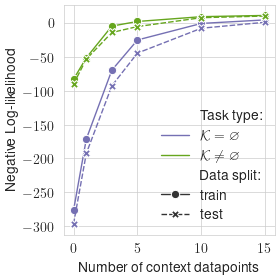

In [76]:
train_summary_df['split'] = 'train' 
test_summary_df['split']= 'test'

plot_df = pd.concat([train_summary_df, test_summary_df])
plot_df = plot_df[
    ((plot_df.model_name == 'INP') & (plot_df.eval_type == 'b')) |
    ((plot_df.model_name == 'NP') & (plot_df.eval_type == 'raw'))
]

plot_df['mean'] = -plot_df['mean']
plot_df['eval_type'] = plot_df['eval_type'].map({
    'raw': r'$\mathcal{K} = \varnothing$',
    'b': r'$\mathcal{K} \neq \varnothing$'
})

fig, ax = plt.subplots(figsize=(3,3))
sns.lineplot(
    plot_df, x='num_context', y='mean', hue='eval_type', 
    style='split', palette=['C2', 'C4'], markers=True
)

ax.set_ylabel('Negative Log-likelihood')
ax.set_xlabel('Number of context datapoints')

handles, labels = ax.get_legend_handles_labels()

labels[0] = 'Task type:'
labels[3] = 'Data split:'

plt.legend(labels=labels, handles=handles)
plt.tight_layout()
plt.show()